In [1]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN


In [2]:
# VGG-19, 19-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
# License: non-commercial use only

# Download pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19.pkl

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGE_W = 600


def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, IMAGE_W, IMAGE_W))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')#, ignore_border=False)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')#, ignore_border=False)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')#, ignore_border=False)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')

    return net

In [3]:
net = build_model()

In [4]:
values = pickle.load(open('vgg19.pkl'))['param values'][:32]
lasagne.layers.set_all_param_values(net['pool5'], values)

In [5]:
original = plt.imread('Tuebingen_Neckarfront.jpg')

In [6]:
styleimage = plt.imread('1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

In [7]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

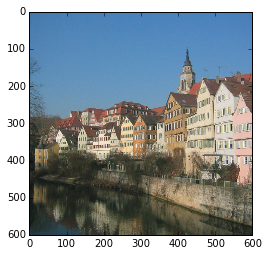

In [8]:
rawim, origim = prep_image(original)
plt.imshow(rawim)

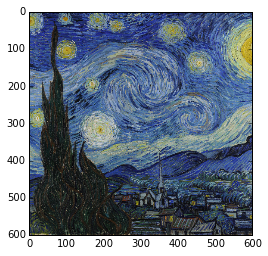

In [9]:
rawim, styleim = prep_image(styleimage)
plt.imshow(rawim)

In [10]:
p = T.tensor4()
a = T.tensor4()
x = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

In [11]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).mean()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

In [12]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net[k] for k in layers}

In [13]:
P = lasagne.layers.get_output(layers.values(), p)
P = [theano.shared(output.eval({p: origim})) for output in P]
P = {k: v for k, v in zip(layers.keys(), P)}

In [14]:
A = lasagne.layers.get_output(layers.values(), a)
A = [theano.shared(output.eval({a: styleim})) for output in A]
A = {k: v for k, v in zip(layers.keys(), A)}

In [15]:
X = lasagne.layers.get_output(layers.values(), x)
X = {k: v for k, v in zip(layers.keys(), X)}

In [16]:
loss = []
loss.append(100.0 * content_loss(P, X, 'conv4_2'))
loss.append(0.2 * style_loss(A, X, 'conv1_1'))
loss.append(0.2 * style_loss(A, X, 'conv2_1'))
loss.append(0.2 * style_loss(A, X, 'conv3_1'))
loss.append(0.2 * style_loss(A, X, 'conv4_1'))
loss.append(0.2 * style_loss(A, X, 'conv5_1'))

In [17]:
grad = T.grad(sum(loss), x)

In [18]:
floss = theano.function([], loss)
fgrad = theano.function([], grad)

def f_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    x.set_value(x0)
    return sum(floss()).astype('float64')

def f_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    x.set_value(x0)
    return np.array(fgrad()).flatten().astype('float64')

In [19]:
x.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))
x0 = x.get_value().astype('float64')
xs = []

for i in range(5):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(f_loss, x0.flatten(), fprime=f_grad, maxfun=50)
    x0 = x.get_value().astype('float64')
    xs.append(x.get_value())

0
1
2
3
4


In [20]:
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)

#    x -= x.min()
#    x /= x.max()
    x = np.clip(x / 255, 0, 1)
    return x

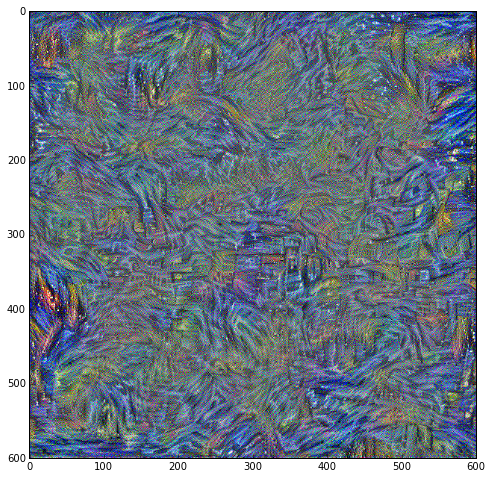

In [21]:
x0 = deprocess(xs[0])
plt.figure(figsize=(8, 8))
plt.imshow(x0)

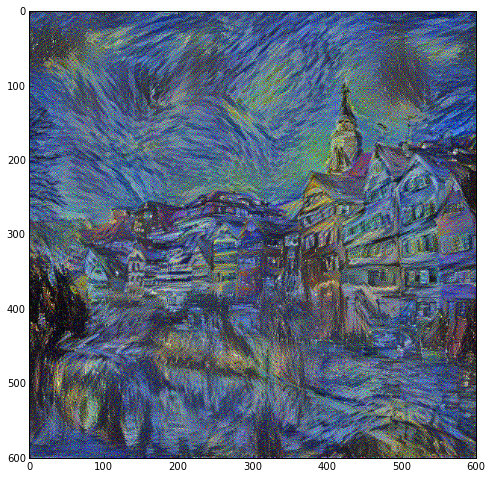

In [22]:
x0 = deprocess(xs[4])
plt.figure(figsize=(8, 8))
plt.imshow(x0)